[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qiuyi-Hong/SHEMS/blob/main/analysisSHEMS_HP_TES.ipynb)

In [1]:
# # Install necessary packages: 
# !pip install pyomo pandas openpyxl matplotlib jupyter

# # Install cbc solver: 
# !sudo apt-get install  coinor-cbc coinor-libcbc-dev 

# # Download necessary files:
# import urllib.request, sys

# urls = [
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_HP_TES.py',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/SHEMS_HP_TES.dat',
#     'https://raw.githubusercontent.com/Qiuyi-Hong/SHEMS/refs/heads/main/data.csv'
#     ]
# file_names = [url.split('/')[-1] for url in urls]

# for i in range(len(urls)):
#     urllib.request.urlretrieve(urls[i], file_names[i])


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from datetime import datetime, timedelta
%matplotlib inline
import pyomo.environ as pyo
from SHEMS_HP_TES import model 

In [3]:
data = pd.read_csv('data.csv')
data.head()

,Unnamed: 0,Electricity Demand (kW),Heat Demand (kW),Solar Generation (kW),Import Price (p/kWh),Export Price (p/kWh),Indoor Temperature,Water Temperature,Solar Radiation (kW/m2),Outdoor Temperature
0,00:00,0.280,0.098,0.0,12.35,6.19,22.0,70.0,0.0,1.94
1,01:00,0.268,0.097,0.0,11.69,5.90,22.0,70.0,0.0,1.84
2,02:00,0.280,0.094,0.0,11.00,5.61,22.0,70.0,0.0,1.92
3,03:00,0.268,0.091,0.0,8.00,4.31,22.0,70.0,0.0,1.93
4,04:00,0.284,0.086,0.0,6.94,3.86,22.0,70.0,0.0,2.21


In [4]:
# Solar PV generation
eta = 0.157
S = 20
solar_radiation = data["Solar Radiation (kW/m2)"]
outdoor_temp = data["Outdoor Temperature"]

pv = eta * S * solar_radiation *(1 - 0.005 * (outdoor_temp - 25))

In [5]:
# COP of heat pump
a = -0.066
b = 5.7
indoor_temp = data["Indoor Temperature"]
water_temp = data["Water Temperature"]
COP = a * (water_temp - indoor_temp) + b

In [6]:
T = 24
delta_t = 1
demand_ele = data["Electricity Demand (kW)"]
demand_heat = data["Heat Demand (kW)"]
# pv = data["Solar Generation (kW)"]
ele_import_price = data["Import Price (p/kWh)"]
ele_export_price = data["Export Price (p/kWh)"]


# SHEMS

In [7]:
shems = model.create_instance("SHEMS_HP_TES.dat", namespace="base")

In [8]:
for t in range(1,T+1):
    shems.d_ele._data[t].value = demand_ele[t-1]
    shems.d_heat._data[t].value = demand_heat[t-1]
    shems.p_pv._data[t].value = pv[t-1]
    shems.pi_import._data[t].value = ele_import_price[t-1]
    shems.pi_export._data[t].value = ele_export_price[t-1]
    shems.COP._data[t].value = COP[t-1]

In [9]:
from sys import platform

if platform == "linux":
    # linux
    solver = pyo.SolverFactory('cbc', executable='/usr/bin/cbc')
elif platform == "darwin":
    # OS X
    solver = pyo.SolverFactory('cbc')

solver.solve(shems)

{'Problem': [{'Name': 'unknown', 'Lower bound': 44.35596195, 'Upper bound': 44.35596195, 'Number of objectives': 1, 'Number of constraints': 159, 'Number of variables': 205, 'Number of binary variables': 120, 'Number of integer variables': 120, 'Number of nonzeros': 48, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 0.01, 'Wallclock time': 0.01, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}, 'Black box': {'Number of iterations': 0}}, 'Error rc': 0, 'Time': 0.02574014663696289}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Visualisation

In [10]:
# Values of decision variables
values = pd.DataFrame(data={'p_c_BESS': [shems.p_c_BESS._data[t].value for t in range(1,T+1)],
                      'p_d_BESS': [shems.p_d_BESS._data[t].value for t in range(1,T+1)],
                      'E_BESS': [shems.E_BESS._data[t].value for t in range(1,T+1)],
                      'q_HP': [shems.q_HP._data[t].value for t in range(1,T+1)],
                      'p_HP': [shems.p_HP._data[t].value for t in range(1,T+1)],
                      'q_c_TES': [shems.q_c_TES._data[t].value for t in range(1,T+1)],
                      'q_d_TES': [shems.q_d_TES._data[t].value for t in range(1,T+1)],
                      'Q_TES': [shems.Q_TES._data[t].value for t in range(1,T+1)],
                      'p_import': [shems.p_import._data[t].value for t in range(1,T+1)],
                      'p_export': [shems.p_export._data[t].value for t in range(1,T+1)]})
                      

In [11]:
values

,p_c_BESS,p_d_BESS,E_BESS,q_HP,p_HP,q_c_TES,q_d_TES,Q_TES,p_import,p_export
0,0.000000,0.280000,3.212286,0.000000,0.000000,0.000000,0.098,4.898000,0.000000,0.000000
1,0.000000,0.268000,2.936816,0.000000,0.000000,0.000000,0.097,4.797020,0.000000,0.000000
2,0.000000,0.280000,2.649102,0.000000,0.000000,0.000000,0.094,4.699102,0.000000,0.000000
3,0.000000,0.000000,2.647102,0.000000,0.000000,0.000000,0.091,4.604245,0.268000,0.000000
4,3.000000,0.000000,5.585102,0.000000,0.000000,0.000000,0.086,4.514490,3.284000,0.000000
5,0.000000,2.380016,3.154514,0.000000,0.000000,0.000000,0.081,4.429837,0.659984,0.000000
6,0.000000,3.000000,0.091289,0.000000,0.000000,0.000000,0.078,4.348245,1.258369,0.000000
7,0.000000,0.087504,0.000000,0.000000,0.000000,0.000000,0.076,4.268694,0.000000,0.000000
8,0.004082,0.000000,0.002000,0.000000,0.000000,0.000000,0.072,4.193225,0.000000,0.181209
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066,4.123878,0.000000,0.366575


In [12]:
p_c_BESS = [shems.p_c_BESS._data[t].value for t in range(1,T+1)]
p_d_BESS = [shems.p_d_BESS._data[t].value for t in range(1,T+1)]
E_BESS = [shems.E_BESS._data[t].value for t in range(1,T+1)]
q_HP = [shems.q_HP._data[t].value for t in range(1,T+1)]
p_HP = [shems.p_HP._data[t].value for t in range(1,T+1)]
q_c_TES = [shems.q_c_TES._data[t].value for t in range(1,T+1)]
q_d_TES = [shems.q_d_TES._data[t].value for t in range(1,T+1)]
Q_TES = [shems.Q_TES._data[t].value for t in range(1,T+1)]
p_import = [shems.p_import._data[t].value for t in range(1,T+1)]
p_export = [shems.p_export._data[t].value for t in range(1,T+1)]

d_ele = [shems.d_ele._data[t].value for t in range(1,T+1)]
d_heat = [shems.d_heat._data[t].value for t in range(1,T+1)]
p_pv = [shems.p_pv._data[t].value for t in range(1,T+1)]

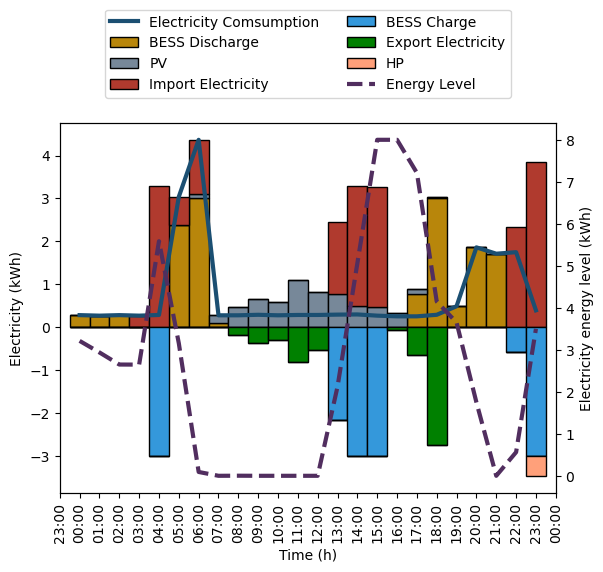

In [13]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

start_time = datetime(2023, 4, 9)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=60)*i for i in range(24)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_ele), label="Electricity Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(p_d_BESS)*delta_t, width=bar_width, label="BESS Discharge", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.array(p_pv)*delta_t, bottom=np.array(p_d_BESS)*delta_t, width=bar_width, label="PV", color="#778899", edgecolor="black")

ax1.bar(time_range, np.array(p_import), bottom=np.array(p_pv)*delta_t + np.array(p_d_BESS)*delta_t, width=bar_width, align='center', label="Import Electricity", color="#B03A2E", edgecolor="black")

ax1.bar(time_range, np.negative(p_c_BESS)*delta_t, width=bar_width, label="BESS Charge", color="#3498DB", edgecolor="black")

ax1.bar(time_range, np.negative(p_export), bottom=np.negative(p_c_BESS)*delta_t, width=bar_width, label="Export Electricity", color="#008000", edgecolor="black")

ax1.bar(time_range, np.negative(p_HP)*delta_t, bottom=np.negative(p_export) + np.negative(p_c_BESS)*delta_t, width=bar_width, label="HP", color="#FFA07A", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=60), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap


ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Electricity (kWh)")

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(E_BESS), label="Energy Level", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("Electricity energy level (kWh)")
# ax2.legend()

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig("shems_electricity.pdf", bbox_inches='tight')
plt.show()

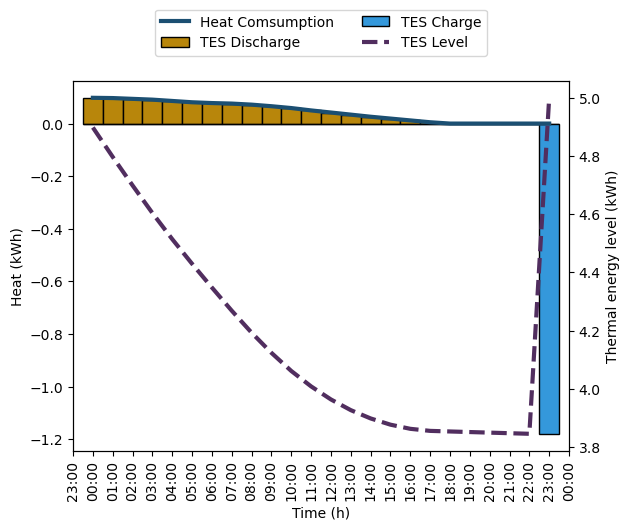

In [14]:
fig, ax1 = plt.subplots()
lineStyle = ["-", "-.", "--", ":"]    
patterns = [ "/" , "\\", "*" , "+" , "-", "o", "O", "x", "*", "|"]

start_time = datetime(2023, 4, 9)  # Arbitrary date, time is what matters here
end_time = start_time + timedelta(hours=24)
time_range = [start_time + timedelta(minutes=60)*i for i in range(24)]
bar_width = (time_range[1] - time_range[0]).total_seconds() / (24*60*60)  # Convert to fraction of a day

ax1.plot(time_range, np.array(d_heat), label="Heat Comsumption", color="#1B4F72", linestyle=lineStyle[0], linewidth=3)

ax1.bar(time_range, np.array(q_d_TES)*delta_t, width=bar_width, label="TES Discharge", color="#B8860B", edgecolor="black")

ax1.bar(time_range, np.negative(q_c_TES)*delta_t, width=bar_width, label="TES Charge", color="#3498DB", edgecolor="black")

# Formatting the x-axis to display time in HH:MM format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting x-axis limits
ax1.set_xlim(start_time - timedelta(minutes=60), end_time)

# Setting x-axis ticks to be every half hour
ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 60], interval=1))

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

ax1.set_xlabel("Time (h)")
ax1.set_ylabel("Heat (kWh)")

# Second y-axis
ax2 = ax1.twinx() 
ax2.plot(time_range, np.array(Q_TES), label="TES Level", color="#512E5F", linestyle=lineStyle[2], linewidth=3)  
ax2.set_ylabel("Thermal energy level (kWh)")
# ax2.legend()

# Collect handles and labels for both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Combine handles and labels
all_handles = handles1 + handles2
all_labels = labels1 + labels2

# Create a single legend
ax1.legend(all_handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.savefig("shems_heat.pdf", bbox_inches='tight')
plt.show()